# Using MIOFlow to discover cell trajectories in Spatial Data

Goals:
- Preprocess data to be used on downstream investigation

## Installation

```bash
pip install mioflow
```

## Import Libraries

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import phate
import torch
import networkx as nx
from torch_geometric.utils import from_networkx
import pickle

## [Optional] Downloading 10X data

### Downloading Data 

# 1. Data Preprocessing


In [2]:
def create_khop_directed_graph(G, k=3):
    """
    Converts a given graph into a directed graph where each node is connected to its 3-hop neighbors.
    
    Args:
    - G (networkx.Graph): The original undirected NetworkX graph.
    
    Returns:
    - new_data (torch_geometric.data.Data): The new directed graph in PyTorch Geometric format.
    - pos (dict): The positions of the nodes for plotting.
    """
    
    # Convert the NetworkX graph to PyTorch Geometric Data object
    data = from_networkx(G)

    # Identify 3-hop neighbors and create a new directed edge index
    new_edges = []

    for node in range(data.num_nodes):
        # Find all nodes within a 3-hop neighborhood
        neighbors_within_k_hops = nx.single_source_shortest_path_length(G, node, cutoff=k).keys()
        
        # Create directed edges from the k-hop neighbors to this node
        for neighbor in neighbors_within_k_hops:
            if node != neighbor:
                new_edges.append([neighbor, node])  # Directed edge from neighbor to node

    # Convert the list of edges to a tensor
    new_edge_index = torch.tensor(new_edges, dtype=torch.long).t().contiguous()

    # Create a new PyTorch Geometric Data object with the new edge index
    new_data = data.clone()
    new_data.edge_index = new_edge_index

    # Store positions for consistent plotting
    # pos = nx.spring_layout(G)  # Use a spring layout for visualization

    return new_data

In [5]:
# Load dataset and LR pairs
file = open('data/axolotl/Axolotl_batch_corrected.pkl', 'rb')
adata = pickle.load(file)
# LR_pairs = pd.read_csv("/vast/palmer/pi/krishnaswamy_smita/Brett/RNAseq/nbs/ARTISTA_LR_pairs.csv")
# lr_pairs = list(LR_pairs['Ligand'])  + list(LR_pairs['Receptor'])

KeyError: '_adata_ref'

# 2. Dimensionality Reduction

### Embedding Data Using PCA and PHATE

Here we need to embed our data into a lower dimentional space.

This allows us to compute distances on PCA space and regularize by PHATE.

For this we simply compute PCA from scanpy.

In [3]:
n_components = 50
#This function will change adata inplace and add X_pca into adata.obsm
pca_df = sc.pp.pca(adata, n_comps=n_components)

NameError: name 'adata' is not defined

In [36]:
adata

AnnData object with n_obs × n_vars = 16826 × 17845
    obs: 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'timepoint_colors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


### 2.2. Embedding Data Using PHATE

We are going to run PHATE over the lower dimensional PCA space.

#### 2.2.1 Instantiating the PHATE estimator

The API of PHATE models that of Scikit Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/).

We'll just use the default parameters for now, but the following parameters can be tuned (read our documentation at [phate.readthedocs.io](https://phate.readthedocs.io/) to learn more):

* `knn` : Number of nearest neighbors (default: 5). Increase this (e.g. to 20) if your PHATE embedding appears very disconnected. You should also consider increasing `knn` if your dataset is extremely large (e.g. >100k cells)
* `decay` : Alpha decay (default: 15). Decreasing `decay` increases connectivity on the graph, increasing `decay` decreases connectivity. This rarely needs to be tuned. Set it to `None` for a k-nearest neighbors kernel.
* `t` : Number of times to power the operator (default: 'auto'). This is equivalent to the amount of smoothing done to the data. It is chosen automatically by default, but you can increase it if your embedding lacks structure, or decrease it if the structure looks too compact.
* `gamma` : Informational distance constant (default: 1). `gamma=1` gives the PHATE log potential, but other informational distances can be interesting. If most of the points seem concentrated in one section of the plot, you can try `gamma=0`.

Here's the simplest way to apply PHATE:

In [37]:
phate_operator = phate.PHATE(n_jobs=-2,n_components=2)

X_phate = phate_operator.fit_transform(adata.obsm['X_pca'])

# Here we add the X_phate to adata
# X_phate is the embedding of the data and can also be used for visualization

adata.obsm['X_phate'] = X_phate


Calculating PHATE...
  Running PHATE on 16826 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 3.85 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 3.91 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.43 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.53 seconds.
  Calculated landmark operator in 2.34 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 0.93 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.36 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.90 seconds.
Calculated PHATE in 9.44 seconds.


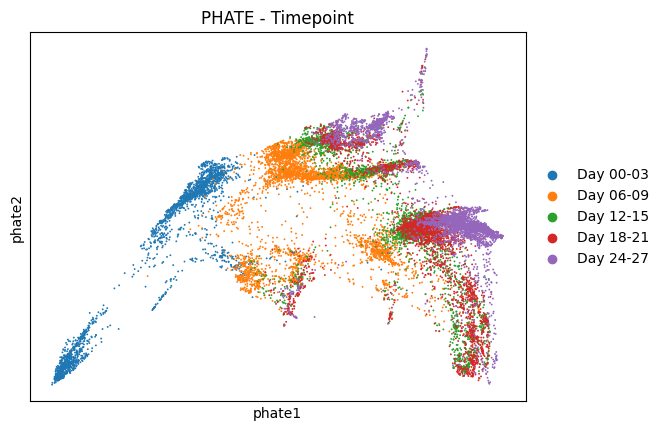

In [38]:
# Visualize PHATE colored by timepoint
sc.pl.embedding(adata, basis='phate', color='timepoint', cmap="Spectral",title='PHATE - Timepoint')

# 2. Choosing a feature to find trajectories

We want our trajectories to follow some dynamics that we want to discover trends about.
Let's start by looking at our PHATE space. This is the latent space we want to find trajectories in.

Now, we need to choose a feature to "guide" our space. Let's check the avalable features:

In [39]:
adata.obs

,timepoint,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCGTGCAGAAA-1,Day 00-03,1581,4602.0,125.0,2.716210
AAACGCACCGGTAT-1,Day 00-03,2550,9558.0,252.0,2.636535
AAACGCACCTATTC-1,Day 00-03,2316,8084.0,224.0,2.770905
AAAGATCTCTGCTC-1,Day 00-03,1848,5463.0,132.0,2.416255
AAAGATCTGGTACT-1,Day 00-03,2350,8797.0,214.0,2.432647
...,...,...,...,...,...
TTTCGAACTTCTCA-1,Day 24-27,1132,2582.0,34.0,1.316809
TTTCTACTCTTATC-1,Day 24-27,1115,2453.0,47.0,1.916021
TTTCTACTTGAGCT-1,Day 24-27,1031,2330.0,16.0,0.686695
TTTGCATGATGACC-1,Day 24-27,927,2005.0,55.0,2.743142


In our case, we know we want to get trajectories over the time samples of our collected data.

We want trajectories that go from the initial sample all the way to the final time point, while following the data structure (manifold)

So we will use the 'time_label'.

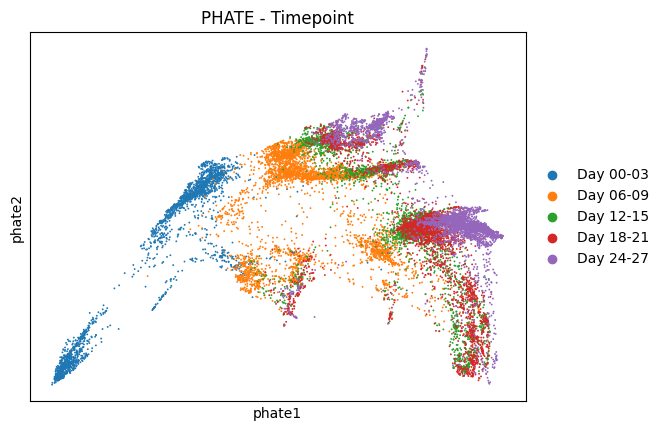

In [40]:
# Visualize PHATE colored by timepoint
sc.pl.embedding(adata, basis='phate', color='timepoint', cmap="Spectral",title='PHATE - Timepoint')

# 3. Preparing the data to MIOFlow

The MIOFlow algorithm expects data in a standart format, so we cannot simply send our adata directly to the algorithm.
The algorithm expects discreate timelabels to flow.

We just need to create the time_bin column.


In [41]:
# Create a numerical bin for each timepoint
print("Creating time_bin from timepoints...")
adata.obs['time_bin'] = adata.obs['timepoint'].map({
    'Day 00-03': 0.,
    'Day 06-09': 1.,
    'Day 12-15': 2.,
    'Day 18-21': 3.,
    'Day 24-27': 4.,
})
adata.obs[['timepoint', 'time_bin']].head()

Creating time_bin from timepoints...


,timepoint,time_bin
AAACCGTGCAGAAA-1,Day 00-03,0.0
AAACGCACCGGTAT-1,Day 00-03,0.0
AAACGCACCTATTC-1,Day 00-03,0.0
AAAGATCTCTGCTC-1,Day 00-03,0.0
AAAGATCTGGTACT-1,Day 00-03,0.0


Perfect! We have the necessary input for MIOFlow. Let's do a final check that this data contains everything we want to infer on top.

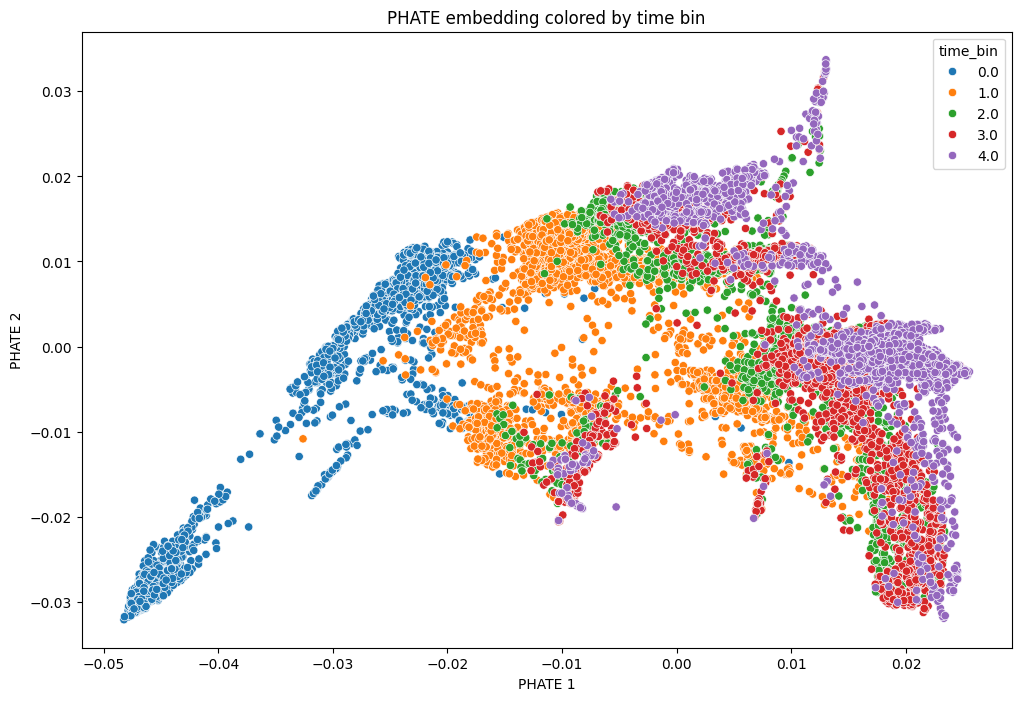

In [42]:
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=adata.obsm['X_phate'][:, 0],
    y=adata.obsm['X_phate'][:, 1],
    hue=adata.obs['time_bin'],
    palette='tab10'
)
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')
plt.title('PHATE embedding colored by time bin')
plt.show()

If your data looks right, and we can see a path for the trajectories to follow, we can move on to training the MIOFlow algorithm.

# 4. Saving the preprocessed data

Save the fully preprocessed `AnnData` object so it can be loaded directly in downstream notebooks without repeating all preprocessing steps.

In [43]:
save_path = os.path.join(data_path, 'preprocessed_eb_adata.h5ad')
adata.write_h5ad(save_path)
print(f"Saved preprocessed AnnData to: {save_path}")
print(adata)

Saved preprocessed AnnData to: data/scRNAseq/preprocessed_eb_adata.h5ad
AnnData object with n_obs × n_vars = 16826 × 17845
    obs: 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'time_bin'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'timepoint_colors', 'pca'
    obsm: 'X_pca', 'X_phate'
    varm: 'PCs'
